In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
        self.commitment_cost = commitment_cost

    def forward(self, inputs):
        flat_inputs = inputs.view(-1, self.embedding_dim)
        distances = (
            torch.sum(flat_inputs**2, dim=1, keepdim=True)
            + torch.sum(self.embedding.weight**2, dim=1)
            - 2 * torch.matmul(flat_inputs, self.embedding.weight.t())
        )
        encoding_indices = torch.argmin(distances, dim=1)
        encodings = F.one_hot(encoding_indices, self.num_embeddings).type(inputs.dtype)
        quantized = torch.matmul(encodings, self.embedding.weight).view_as(inputs)
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss
        quantized = inputs + (quantized - inputs).detach()
        return quantized, loss, encoding_indices.view(inputs.shape[0], inputs.shape[2], inputs.shape[3])

class VQVAE(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=128, embedding_dim=64, num_embeddings=512, commitment_cost=0.25):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 4, 2, 1),  # 64->32
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 4, 2, 1),   # 32->16
            nn.ReLU(),
            nn.Conv2d(hidden_dim, embedding_dim, 1)       # kanały = embedding_dim
        )
        self.quantizer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)

        self.decoder_convT1 = nn.ConvTranspose2d(embedding_dim, hidden_dim, 4, 2, 1)  # 16->32
        self.decoder_relu1 = nn.ReLU()
        self.decoder_convT2 = nn.ConvTranspose2d(hidden_dim, hidden_dim, 4, 2, 1)     # 32->64
        self.decoder_relu2 = nn.ReLU()
        # Usunięto trzecią warstwę ConvTranspose2d
        self.decoder_conv = nn.Conv2d(hidden_dim, in_channels, 1)
        self.decoder_sigmoid = nn.Sigmoid()

    def forward(self, x):
        z = self.encoder(x)  # (B, embedding_dim, 16, 16)
        quantized, vq_loss, _ = self.quantizer(z)

        x = self.decoder_convT1(quantized)  # 16->32
        x = self.decoder_relu1(x)

        x = self.decoder_convT2(x)           # 32->64
        x = self.decoder_relu2(x)

        x = self.decoder_conv(x)             # (B, 3, 64, 64)
        x = self.decoder_sigmoid(x)

        return x, vq_loss

    def decode(self, quantized):
        x = self.decoder_convT1(quantized)
        x = self.decoder_relu1(x)

        x = self.decoder_convT2(x)
        x = self.decoder_relu2(x)

        x = self.decoder_conv(x)
        x = self.decoder_sigmoid(x)
        return x


    def encode_indices(self, x):
        z = self.encoder(x)
        _, _, indices = self.quantizer(z)
        return indices


In [2]:
import torch
import torch.nn as nn

class PixelCNN(nn.Module):
    def __init__(self, num_embeddings, image_size, n_channels=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, n_channels, 7, padding=3),
            nn.ReLU(),
            *[nn.Sequential(nn.Conv2d(n_channels, n_channels, 3, padding=1), nn.ReLU()) for _ in range(6)],
            nn.Conv2d(n_channels, num_embeddings, 1)
        )
        self.image_size = image_size

    def forward(self, x):
        return self.net(x)

    def sample(self, device, num_samples):
        samples = torch.zeros((num_samples, 1, self.image_size, self.image_size), dtype=torch.long).to(device)
        for i in range(self.image_size):
            for j in range(self.image_size):
                logits = self.forward(samples.float())
                probs = torch.softmax(logits[:, :, i, j], dim=1)
                samples[:, 0, i, j] = torch.multinomial(probs, 1).squeeze(-1)
        return samples


In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import save_image
import os
from tqdm import tqdm
epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = ImageFolder("data/training", transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

vqvae = VQVAE().to(device)
optimizer = torch.optim.Adam(vqvae.parameters(), lr=2e-4)

for epoch in range(epochs):
    total_loss = 0
    with tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}") as pbar:
        for x, _ in pbar:
            x = x.to(device)
            x_recon, vq_loss = vqvae(x)
            recon_loss = torch.nn.functional.mse_loss(x_recon, x)
            loss = recon_loss + vq_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
    print(f"Epoch {epoch+1}: avg loss={total_loss / len(loader):.4f}")



Epoch 1/50: 100%|██████████| 467/467 [00:17<00:00, 26.45it/s, loss=0.329]


Epoch 1: avg loss=0.4104


Epoch 2/50: 100%|██████████| 467/467 [00:16<00:00, 28.35it/s, loss=0.229]


Epoch 2: avg loss=0.2853


Epoch 3/50: 100%|██████████| 467/467 [00:16<00:00, 28.07it/s, loss=0.172]


Epoch 3: avg loss=0.1977


Epoch 4/50: 100%|██████████| 467/467 [00:16<00:00, 28.16it/s, loss=0.173]


Epoch 4: avg loss=0.1703


Epoch 5/50: 100%|██████████| 467/467 [00:16<00:00, 28.82it/s, loss=0.134]


Epoch 5: avg loss=0.1433


Epoch 6/50: 100%|██████████| 467/467 [00:16<00:00, 29.11it/s, loss=0.116]


Epoch 6: avg loss=0.1300


Epoch 7/50: 100%|██████████| 467/467 [00:16<00:00, 28.83it/s, loss=0.128]


Epoch 7: avg loss=0.1242


Epoch 8/50: 100%|██████████| 467/467 [00:16<00:00, 28.46it/s, loss=0.128]


Epoch 8: avg loss=0.1231


Epoch 9/50: 100%|██████████| 467/467 [00:16<00:00, 28.03it/s, loss=0.108]


Epoch 9: avg loss=0.1213


Epoch 10/50: 100%|██████████| 467/467 [00:16<00:00, 29.14it/s, loss=0.135] 


Epoch 10: avg loss=0.1184


Epoch 11/50: 100%|██████████| 467/467 [00:15<00:00, 29.82it/s, loss=0.119] 


Epoch 11: avg loss=0.1148


Epoch 12/50: 100%|██████████| 467/467 [00:15<00:00, 29.89it/s, loss=0.0962]


Epoch 12: avg loss=0.1116


Epoch 13/50: 100%|██████████| 467/467 [00:15<00:00, 30.01it/s, loss=0.12]  


Epoch 13: avg loss=0.1081


Epoch 14/50: 100%|██████████| 467/467 [00:15<00:00, 29.88it/s, loss=0.104] 


Epoch 14: avg loss=0.1053


Epoch 15/50: 100%|██████████| 467/467 [00:15<00:00, 29.95it/s, loss=0.107] 


Epoch 15: avg loss=0.1031


Epoch 16/50: 100%|██████████| 467/467 [00:15<00:00, 29.78it/s, loss=0.0995]


Epoch 16: avg loss=0.1014


Epoch 17/50: 100%|██████████| 467/467 [00:15<00:00, 29.83it/s, loss=0.0928]


Epoch 17: avg loss=0.1001


Epoch 18/50: 100%|██████████| 467/467 [00:15<00:00, 29.84it/s, loss=0.1]   


Epoch 18: avg loss=0.0992


Epoch 19/50: 100%|██████████| 467/467 [00:15<00:00, 29.91it/s, loss=0.104] 


Epoch 19: avg loss=0.0985


Epoch 20/50: 100%|██████████| 467/467 [00:15<00:00, 30.05it/s, loss=0.0937]


Epoch 20: avg loss=0.0977


Epoch 21/50: 100%|██████████| 467/467 [00:15<00:00, 29.90it/s, loss=0.09]  


Epoch 21: avg loss=0.0969


Epoch 22/50: 100%|██████████| 467/467 [00:15<00:00, 29.92it/s, loss=0.082] 


Epoch 22: avg loss=0.0959


Epoch 23/50: 100%|██████████| 467/467 [00:15<00:00, 29.71it/s, loss=0.103] 


Epoch 23: avg loss=0.0951


Epoch 24/50: 100%|██████████| 467/467 [00:15<00:00, 29.75it/s, loss=0.0971]


Epoch 24: avg loss=0.0943


Epoch 25/50: 100%|██████████| 467/467 [00:15<00:00, 29.80it/s, loss=0.0896]


Epoch 25: avg loss=0.0937


Epoch 26/50: 100%|██████████| 467/467 [00:15<00:00, 29.78it/s, loss=0.0914]


Epoch 26: avg loss=0.0929


Epoch 27/50: 100%|██████████| 467/467 [00:15<00:00, 29.73it/s, loss=0.0996]


Epoch 27: avg loss=0.0923


Epoch 28/50: 100%|██████████| 467/467 [00:15<00:00, 29.78it/s, loss=0.104] 


Epoch 28: avg loss=0.0915


Epoch 29/50: 100%|██████████| 467/467 [00:15<00:00, 29.87it/s, loss=0.106] 


Epoch 29: avg loss=0.0909


Epoch 30/50: 100%|██████████| 467/467 [00:15<00:00, 29.77it/s, loss=0.112] 


Epoch 30: avg loss=0.0901


Epoch 31/50: 100%|██████████| 467/467 [00:15<00:00, 29.83it/s, loss=0.0858]


Epoch 31: avg loss=0.0895


Epoch 32/50: 100%|██████████| 467/467 [00:15<00:00, 29.68it/s, loss=0.0802]


Epoch 32: avg loss=0.0886


Epoch 33/50: 100%|██████████| 467/467 [00:16<00:00, 28.88it/s, loss=0.0869]


Epoch 33: avg loss=0.0880


Epoch 34/50: 100%|██████████| 467/467 [00:17<00:00, 27.40it/s, loss=0.09]  


Epoch 34: avg loss=0.0874


Epoch 35/50: 100%|██████████| 467/467 [00:17<00:00, 27.27it/s, loss=0.0872]


Epoch 35: avg loss=0.0868


Epoch 36/50: 100%|██████████| 467/467 [00:17<00:00, 26.84it/s, loss=0.0932]


Epoch 36: avg loss=0.0863


Epoch 37/50: 100%|██████████| 467/467 [00:17<00:00, 26.99it/s, loss=0.0902]


Epoch 37: avg loss=0.0857


Epoch 38/50: 100%|██████████| 467/467 [00:16<00:00, 27.87it/s, loss=0.0773]


Epoch 38: avg loss=0.0853


Epoch 39/50: 100%|██████████| 467/467 [00:16<00:00, 27.68it/s, loss=0.0784]


Epoch 39: avg loss=0.0846


Epoch 40/50: 100%|██████████| 467/467 [00:16<00:00, 28.37it/s, loss=0.0847]


Epoch 40: avg loss=0.0842


Epoch 41/50: 100%|██████████| 467/467 [00:16<00:00, 27.97it/s, loss=0.0667]


Epoch 41: avg loss=0.0837


Epoch 42/50: 100%|██████████| 467/467 [00:16<00:00, 28.69it/s, loss=0.0836]


Epoch 42: avg loss=0.0831


Epoch 43/50: 100%|██████████| 467/467 [00:16<00:00, 28.80it/s, loss=0.0815]


Epoch 43: avg loss=0.0830


Epoch 44/50: 100%|██████████| 467/467 [00:16<00:00, 28.97it/s, loss=0.074] 


Epoch 44: avg loss=0.0825


Epoch 45/50: 100%|██████████| 467/467 [00:15<00:00, 29.61it/s, loss=0.093] 


Epoch 45: avg loss=0.0820


Epoch 46/50: 100%|██████████| 467/467 [00:15<00:00, 29.71it/s, loss=0.0809]


Epoch 46: avg loss=0.0816


Epoch 47/50: 100%|██████████| 467/467 [00:15<00:00, 29.81it/s, loss=0.0834]


Epoch 47: avg loss=0.0813


Epoch 48/50: 100%|██████████| 467/467 [00:15<00:00, 29.86it/s, loss=0.082] 


Epoch 48: avg loss=0.0808


Epoch 49/50: 100%|██████████| 467/467 [00:15<00:00, 29.90it/s, loss=0.0808]


Epoch 49: avg loss=0.0806


Epoch 50/50: 100%|██████████| 467/467 [00:15<00:00, 29.91it/s, loss=0.085] 

Epoch 50: avg loss=0.0802


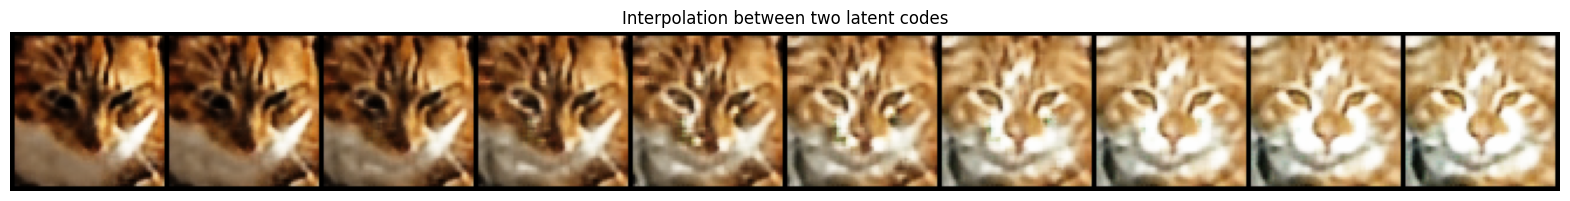

In [18]:
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
def interpolate_latents(z1, z2, steps=8):
    return [z1 * (1 - alpha) + z2 * alpha for alpha in np.linspace(0, 1, steps + 2)]
    
model = vqvae
model.eval()
with torch.no_grad():
    images, _ = next(iter(loader))  # poprawnie pobierz batch obrazów
    images = images.to(device)
    img1 = images[0]
    img2 = images[1]
    z1 = model.encoder(img1.unsqueeze(0))
    z2 = model.encoder(img2.unsqueeze(0))
    interpolated = interpolate_latents(z1, z2)
    decoded = [model.decode(z) for z in interpolated]
    decoded = torch.cat(decoded)
    decoded = decoded.clamp(0, 1)
    grid = make_grid(decoded, nrow=10)
    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.title("Interpolation between two latent codes")
    plt.show()



In [15]:

# Zapis kodów latentnych
codes = []
print("Encoding latent indices...")
with torch.no_grad():
    for x, _ in tqdm(loader, desc="Encoding"):
        x = x.to(device)
        idx = vqvae.encode_indices(x)
        codes.append(idx)
codes = torch.cat(codes)
# Trening PixelCNN na kodach
pixelcnn = PixelCNN(num_embeddings=512, image_size=codes.shape[1]).to(device)
optimizer_pcnn = torch.optim.Adam(pixelcnn.parameters(), lr=2e-4)

codes = codes.unsqueeze(1).float()  # [B, 1, H, W]

print("Training PixelCNN...")
for epoch in range(epochs):
    total_loss = 0
    with tqdm(range(0, codes.size(0), 64), desc=f"PixelCNN Epoch {epoch+1}/{epochs}") as pbar:
        for i in pbar:
            batch = codes[i:i+64].to(device)
            logits = pixelcnn(batch)
            loss = torch.nn.functional.cross_entropy(logits, batch.squeeze(1).long())
            optimizer_pcnn.zero_grad()
            loss.backward()
            optimizer_pcnn.step()
            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
    print(f"[PixelCNN] Epoch {epoch+1}: avg loss={total_loss / (codes.size(0)//64):.4f}")


Encoding latent indices...


Encoding: 100%|██████████| 467/467 [00:09<00:00, 49.58it/s]


Training PixelCNN...


PixelCNN Epoch 1/50: 100%|██████████| 467/467 [00:01<00:00, 248.37it/s, loss=3.88]


[PixelCNN] Epoch 1: avg loss=4.9095


PixelCNN Epoch 2/50: 100%|██████████| 467/467 [00:01<00:00, 262.14it/s, loss=3.52]


[PixelCNN] Epoch 2: avg loss=3.7674


PixelCNN Epoch 3/50: 100%|██████████| 467/467 [00:01<00:00, 261.90it/s, loss=3.32]


[PixelCNN] Epoch 3: avg loss=3.5308


PixelCNN Epoch 4/50: 100%|██████████| 467/467 [00:01<00:00, 256.22it/s, loss=3.22]


[PixelCNN] Epoch 4: avg loss=3.3980


PixelCNN Epoch 5/50: 100%|██████████| 467/467 [00:01<00:00, 261.62it/s, loss=3.13]


[PixelCNN] Epoch 5: avg loss=3.3031


PixelCNN Epoch 6/50: 100%|██████████| 467/467 [00:01<00:00, 262.33it/s, loss=3.06]


[PixelCNN] Epoch 6: avg loss=3.2299


PixelCNN Epoch 7/50: 100%|██████████| 467/467 [00:01<00:00, 274.09it/s, loss=3]   


[PixelCNN] Epoch 7: avg loss=3.1688


PixelCNN Epoch 8/50: 100%|██████████| 467/467 [00:01<00:00, 274.45it/s, loss=2.93]


[PixelCNN] Epoch 8: avg loss=3.1163


PixelCNN Epoch 9/50: 100%|██████████| 467/467 [00:01<00:00, 251.18it/s, loss=2.86]


[PixelCNN] Epoch 9: avg loss=3.0679


PixelCNN Epoch 10/50: 100%|██████████| 467/467 [00:01<00:00, 242.36it/s, loss=2.81]


[PixelCNN] Epoch 10: avg loss=3.0235


PixelCNN Epoch 11/50: 100%|██████████| 467/467 [00:01<00:00, 239.35it/s, loss=2.76]


[PixelCNN] Epoch 11: avg loss=2.9786


PixelCNN Epoch 12/50: 100%|██████████| 467/467 [00:01<00:00, 234.49it/s, loss=2.73]


[PixelCNN] Epoch 12: avg loss=2.9455


PixelCNN Epoch 13/50: 100%|██████████| 467/467 [00:01<00:00, 247.85it/s, loss=2.7] 


[PixelCNN] Epoch 13: avg loss=2.9158


PixelCNN Epoch 14/50: 100%|██████████| 467/467 [00:01<00:00, 263.74it/s, loss=2.68]


[PixelCNN] Epoch 14: avg loss=2.8882


PixelCNN Epoch 15/50: 100%|██████████| 467/467 [00:01<00:00, 266.50it/s, loss=2.69]


[PixelCNN] Epoch 15: avg loss=2.8860


PixelCNN Epoch 16/50: 100%|██████████| 467/467 [00:01<00:00, 268.48it/s, loss=2.64]


[PixelCNN] Epoch 16: avg loss=2.8342


PixelCNN Epoch 17/50: 100%|██████████| 467/467 [00:01<00:00, 264.81it/s, loss=2.61]


[PixelCNN] Epoch 17: avg loss=2.8457


PixelCNN Epoch 18/50: 100%|██████████| 467/467 [00:01<00:00, 260.13it/s, loss=2.59]


[PixelCNN] Epoch 18: avg loss=2.7906


PixelCNN Epoch 19/50: 100%|██████████| 467/467 [00:01<00:00, 254.76it/s, loss=2.56]


[PixelCNN] Epoch 19: avg loss=2.7844


PixelCNN Epoch 20/50: 100%|██████████| 467/467 [00:01<00:00, 254.55it/s, loss=2.57]


[PixelCNN] Epoch 20: avg loss=2.7463


PixelCNN Epoch 21/50: 100%|██████████| 467/467 [00:01<00:00, 261.94it/s, loss=2.54]


[PixelCNN] Epoch 21: avg loss=2.7623


PixelCNN Epoch 22/50: 100%|██████████| 467/467 [00:01<00:00, 261.55it/s, loss=2.51]


[PixelCNN] Epoch 22: avg loss=2.7130


PixelCNN Epoch 23/50: 100%|██████████| 467/467 [00:01<00:00, 246.92it/s, loss=2.5] 


[PixelCNN] Epoch 23: avg loss=2.7013


PixelCNN Epoch 24/50: 100%|██████████| 467/467 [00:01<00:00, 270.93it/s, loss=2.5] 


[PixelCNN] Epoch 24: avg loss=2.6847


PixelCNN Epoch 25/50: 100%|██████████| 467/467 [00:01<00:00, 270.36it/s, loss=2.5] 


[PixelCNN] Epoch 25: avg loss=2.6748


PixelCNN Epoch 26/50: 100%|██████████| 467/467 [00:01<00:00, 261.87it/s, loss=2.47]


[PixelCNN] Epoch 26: avg loss=2.6632


PixelCNN Epoch 27/50: 100%|██████████| 467/467 [00:01<00:00, 264.71it/s, loss=2.45]


[PixelCNN] Epoch 27: avg loss=2.6500


PixelCNN Epoch 28/50: 100%|██████████| 467/467 [00:01<00:00, 261.66it/s, loss=2.43]


[PixelCNN] Epoch 28: avg loss=2.6407


PixelCNN Epoch 29/50: 100%|██████████| 467/467 [00:01<00:00, 265.32it/s, loss=2.42]


[PixelCNN] Epoch 29: avg loss=2.6355


PixelCNN Epoch 30/50: 100%|██████████| 467/467 [00:01<00:00, 267.99it/s, loss=2.4] 


[PixelCNN] Epoch 30: avg loss=2.6208


PixelCNN Epoch 31/50: 100%|██████████| 467/467 [00:01<00:00, 262.69it/s, loss=2.38]


[PixelCNN] Epoch 31: avg loss=2.6096


PixelCNN Epoch 32/50: 100%|██████████| 467/467 [00:01<00:00, 257.20it/s, loss=2.37]


[PixelCNN] Epoch 32: avg loss=2.5996


PixelCNN Epoch 33/50: 100%|██████████| 467/467 [00:01<00:00, 259.74it/s, loss=2.35]


[PixelCNN] Epoch 33: avg loss=2.5906


PixelCNN Epoch 34/50: 100%|██████████| 467/467 [00:01<00:00, 253.24it/s, loss=2.34]


[PixelCNN] Epoch 34: avg loss=2.5820


PixelCNN Epoch 35/50: 100%|██████████| 467/467 [00:01<00:00, 251.10it/s, loss=2.32]


[PixelCNN] Epoch 35: avg loss=2.5736


PixelCNN Epoch 36/50: 100%|██████████| 467/467 [00:02<00:00, 221.96it/s, loss=2.31]


[PixelCNN] Epoch 36: avg loss=2.5657


PixelCNN Epoch 37/50: 100%|██████████| 467/467 [00:01<00:00, 238.13it/s, loss=2.3] 


[PixelCNN] Epoch 37: avg loss=2.5582


PixelCNN Epoch 38/50: 100%|██████████| 467/467 [00:01<00:00, 245.18it/s, loss=2.29]


[PixelCNN] Epoch 38: avg loss=2.5502


PixelCNN Epoch 39/50: 100%|██████████| 467/467 [00:02<00:00, 228.70it/s, loss=2.28]


[PixelCNN] Epoch 39: avg loss=2.5434


PixelCNN Epoch 40/50: 100%|██████████| 467/467 [00:01<00:00, 234.15it/s, loss=2.27]


[PixelCNN] Epoch 40: avg loss=2.5359


PixelCNN Epoch 41/50: 100%|██████████| 467/467 [00:01<00:00, 255.11it/s, loss=2.27]


[PixelCNN] Epoch 41: avg loss=2.5291


PixelCNN Epoch 42/50: 100%|██████████| 467/467 [00:01<00:00, 257.92it/s, loss=2.27]


[PixelCNN] Epoch 42: avg loss=2.5229


PixelCNN Epoch 43/50: 100%|██████████| 467/467 [00:01<00:00, 253.25it/s, loss=2.27]


[PixelCNN] Epoch 43: avg loss=2.5158


PixelCNN Epoch 44/50: 100%|██████████| 467/467 [00:01<00:00, 255.19it/s, loss=2.26]


[PixelCNN] Epoch 44: avg loss=2.5108


PixelCNN Epoch 45/50: 100%|██████████| 467/467 [00:01<00:00, 245.54it/s, loss=2.25]


[PixelCNN] Epoch 45: avg loss=2.5031


PixelCNN Epoch 46/50: 100%|██████████| 467/467 [00:01<00:00, 255.83it/s, loss=2.25]


[PixelCNN] Epoch 46: avg loss=2.4965


PixelCNN Epoch 47/50: 100%|██████████| 467/467 [00:01<00:00, 254.00it/s, loss=2.26]


[PixelCNN] Epoch 47: avg loss=2.4913


PixelCNN Epoch 48/50: 100%|██████████| 467/467 [00:01<00:00, 268.82it/s, loss=2.26]


[PixelCNN] Epoch 48: avg loss=2.4853


PixelCNN Epoch 49/50: 100%|██████████| 467/467 [00:01<00:00, 269.76it/s, loss=2.26]


[PixelCNN] Epoch 49: avg loss=2.4802


PixelCNN Epoch 50/50: 100%|██████████| 467/467 [00:01<00:00, 271.53it/s, loss=2.27]

[PixelCNN] Epoch 50: avg loss=2.4742


In [19]:
samples = pixelcnn.sample(device, 64)  # [64, 1, H, W] lub [64, H, W]
samples = samples.squeeze(1).long()    # [64, H, W]

# Zamiana indeksów na embeddingi: [B, H, W] -> [B, H, W, C]
embeddings = vqvae.quantizer.embedding(samples)  

# Zamiana na [B, C, H, W]
embeddings = embeddings.permute(0, 3, 1, 2).contiguous()

# Dekodowanie
with torch.no_grad():
    recon = vqvae.decode(embeddings)   # uzywając metody decode z klasy VQVAE

# Zapis
save_image(recon, "generated/generated_cats_lr_2e-04.png", nrow=8)

In [23]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import save_image
import os
from tqdm import tqdm
epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = ImageFolder("data", transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

vqvae = VQVAE().to(device)
optimizer = torch.optim.Adam(vqvae.parameters(), lr=2e-4)

for epoch in range(epochs):
    total_loss = 0
    with tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}") as pbar:
        for x, _ in pbar:
            x = x.to(device)
            x_recon, vq_loss = vqvae(x)
            recon_loss = torch.nn.functional.mse_loss(x_recon, x)
            loss = recon_loss + vq_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
    print(f"Epoch {epoch+1}: avg loss={total_loss / len(loader):.4f}")



Epoch 1/50: 100%|██████████| 933/933 [00:17<00:00, 53.74it/s, loss=0.333]


Epoch 1: avg loss=0.4338


Epoch 2/50: 100%|██████████| 933/933 [00:17<00:00, 53.92it/s, loss=0.177]


Epoch 2: avg loss=0.2128


Epoch 3/50: 100%|██████████| 933/933 [00:17<00:00, 54.31it/s, loss=0.15] 


Epoch 3: avg loss=0.1641


Epoch 4/50: 100%|██████████| 933/933 [00:17<00:00, 54.29it/s, loss=0.141]


Epoch 4: avg loss=0.1385


Epoch 5/50: 100%|██████████| 933/933 [00:16<00:00, 54.92it/s, loss=0.149]


Epoch 5: avg loss=0.1308


Epoch 6/50: 100%|██████████| 933/933 [00:17<00:00, 54.83it/s, loss=0.126] 


Epoch 6: avg loss=0.1268


Epoch 7/50: 100%|██████████| 933/933 [00:17<00:00, 53.10it/s, loss=0.13]  


Epoch 7: avg loss=0.1199


Epoch 8/50: 100%|██████████| 933/933 [00:17<00:00, 52.79it/s, loss=0.106] 


Epoch 8: avg loss=0.1151


Epoch 9/50: 100%|██████████| 933/933 [00:17<00:00, 52.83it/s, loss=0.1]   


Epoch 9: avg loss=0.1101


Epoch 10/50: 100%|██████████| 933/933 [00:17<00:00, 52.78it/s, loss=0.105] 


Epoch 10: avg loss=0.1054


Epoch 11/50: 100%|██████████| 933/933 [00:18<00:00, 50.93it/s, loss=0.11]  


Epoch 11: avg loss=0.1026


Epoch 12/50: 100%|██████████| 933/933 [00:18<00:00, 51.69it/s, loss=0.0951]


Epoch 12: avg loss=0.1001


Epoch 13/50: 100%|██████████| 933/933 [00:17<00:00, 54.03it/s, loss=0.086] 


Epoch 13: avg loss=0.0981


Epoch 14/50: 100%|██████████| 933/933 [00:17<00:00, 54.44it/s, loss=0.0939]


Epoch 14: avg loss=0.0968


Epoch 15/50: 100%|██████████| 933/933 [00:17<00:00, 54.26it/s, loss=0.0793]


Epoch 15: avg loss=0.0955


Epoch 16/50: 100%|██████████| 933/933 [00:16<00:00, 56.50it/s, loss=0.0955]


Epoch 16: avg loss=0.0942


Epoch 17/50: 100%|██████████| 933/933 [00:17<00:00, 54.33it/s, loss=0.0908]


Epoch 17: avg loss=0.0930


Epoch 18/50: 100%|██████████| 933/933 [00:17<00:00, 54.80it/s, loss=0.0834]


Epoch 18: avg loss=0.0920


Epoch 19/50: 100%|██████████| 933/933 [00:17<00:00, 54.36it/s, loss=0.096] 


Epoch 19: avg loss=0.0909


Epoch 20/50: 100%|██████████| 933/933 [00:17<00:00, 54.33it/s, loss=0.0903]


Epoch 20: avg loss=0.0899


Epoch 21/50: 100%|██████████| 933/933 [00:17<00:00, 54.15it/s, loss=0.0934]


Epoch 21: avg loss=0.0889


Epoch 22/50: 100%|██████████| 933/933 [00:17<00:00, 54.32it/s, loss=0.0832]


Epoch 22: avg loss=0.0881


Epoch 23/50: 100%|██████████| 933/933 [00:17<00:00, 54.31it/s, loss=0.0926]


Epoch 23: avg loss=0.0873


Epoch 24/50: 100%|██████████| 933/933 [00:17<00:00, 54.39it/s, loss=0.0941]


Epoch 24: avg loss=0.0866


Epoch 25/50: 100%|██████████| 933/933 [00:17<00:00, 54.28it/s, loss=0.0904]


Epoch 25: avg loss=0.0858


Epoch 26/50: 100%|██████████| 933/933 [00:17<00:00, 53.00it/s, loss=0.0876]


Epoch 26: avg loss=0.0852


Epoch 27/50: 100%|██████████| 933/933 [00:17<00:00, 52.34it/s, loss=0.074] 


Epoch 27: avg loss=0.0845


Epoch 28/50: 100%|██████████| 933/933 [00:17<00:00, 52.77it/s, loss=0.0846]


Epoch 28: avg loss=0.0841


Epoch 29/50: 100%|██████████| 933/933 [00:18<00:00, 50.90it/s, loss=0.0837]


Epoch 29: avg loss=0.0835


Epoch 30/50: 100%|██████████| 933/933 [00:17<00:00, 52.89it/s, loss=0.0705]


Epoch 30: avg loss=0.0830


Epoch 31/50: 100%|██████████| 933/933 [00:17<00:00, 53.21it/s, loss=0.0979]


Epoch 31: avg loss=0.0826


Epoch 32/50: 100%|██████████| 933/933 [00:17<00:00, 53.43it/s, loss=0.0715]


Epoch 32: avg loss=0.0821


Epoch 33/50: 100%|██████████| 933/933 [00:17<00:00, 53.53it/s, loss=0.0714]


Epoch 33: avg loss=0.0818


Epoch 34/50: 100%|██████████| 933/933 [00:17<00:00, 53.39it/s, loss=0.0742]


Epoch 34: avg loss=0.0816


Epoch 35/50: 100%|██████████| 933/933 [00:17<00:00, 53.84it/s, loss=0.0948]


Epoch 35: avg loss=0.0811


Epoch 36/50: 100%|██████████| 933/933 [00:16<00:00, 55.15it/s, loss=0.0758]


Epoch 36: avg loss=0.0808


Epoch 37/50: 100%|██████████| 933/933 [00:17<00:00, 54.61it/s, loss=0.0851]


Epoch 37: avg loss=0.0805


Epoch 38/50: 100%|██████████| 933/933 [00:17<00:00, 54.43it/s, loss=0.0702]


Epoch 38: avg loss=0.0803


Epoch 39/50: 100%|██████████| 933/933 [00:17<00:00, 54.38it/s, loss=0.0726]


Epoch 39: avg loss=0.0801


Epoch 40/50: 100%|██████████| 933/933 [00:18<00:00, 49.95it/s, loss=0.0645]


Epoch 40: avg loss=0.0798


Epoch 41/50: 100%|██████████| 933/933 [00:18<00:00, 50.62it/s, loss=0.0762]


Epoch 41: avg loss=0.0795


Epoch 42/50: 100%|██████████| 933/933 [00:18<00:00, 51.27it/s, loss=0.0735]


Epoch 42: avg loss=0.0795


Epoch 43/50: 100%|██████████| 933/933 [00:17<00:00, 53.89it/s, loss=0.0958]


Epoch 43: avg loss=0.0791


Epoch 44/50: 100%|██████████| 933/933 [00:17<00:00, 54.17it/s, loss=0.0719]


Epoch 44: avg loss=0.0790


Epoch 45/50: 100%|██████████| 933/933 [00:17<00:00, 54.03it/s, loss=0.101] 


Epoch 45: avg loss=0.0787


Epoch 46/50: 100%|██████████| 933/933 [00:17<00:00, 52.50it/s, loss=0.0754]


Epoch 46: avg loss=0.0786


Epoch 47/50: 100%|██████████| 933/933 [00:17<00:00, 52.81it/s, loss=0.0712]


Epoch 47: avg loss=0.0784


Epoch 48/50: 100%|██████████| 933/933 [00:17<00:00, 52.68it/s, loss=0.0747]


Epoch 48: avg loss=0.0783


Epoch 49/50: 100%|██████████| 933/933 [00:17<00:00, 53.01it/s, loss=0.0756]


Epoch 49: avg loss=0.0781


Epoch 50/50: 100%|██████████| 933/933 [00:17<00:00, 54.18it/s, loss=0.0762]

Epoch 50: avg loss=0.0778


In [24]:

# Zapis kodów latentnych
codes = []
print("Encoding latent indices...")
with torch.no_grad():
    for x, _ in tqdm(loader, desc="Encoding"):
        x = x.to(device)
        idx = vqvae.encode_indices(x)
        codes.append(idx)
codes = torch.cat(codes)
# Trening PixelCNN na kodach
pixelcnn = PixelCNN(num_embeddings=512, image_size=codes.shape[1]).to(device)
optimizer_pcnn = torch.optim.Adam(pixelcnn.parameters(), lr=2e-3)

codes = codes.unsqueeze(1).float()  # [B, 1, H, W]

print("Training PixelCNN...")
for epoch in range(epochs):
    total_loss = 0
    with tqdm(range(0, codes.size(0), 64), desc=f"PixelCNN Epoch {epoch+1}/{epochs}") as pbar:
        for i in pbar:
            batch = codes[i:i+64].to(device)
            logits = pixelcnn(batch)
            loss = torch.nn.functional.cross_entropy(logits, batch.squeeze(1).long())
            optimizer_pcnn.zero_grad()
            loss.backward()
            optimizer_pcnn.step()
            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())
    print(f"[PixelCNN] Epoch {epoch+1}: avg loss={total_loss / (codes.size(0)//64):.4f}")


Encoding latent indices...


Encoding: 100%|██████████| 933/933 [00:09<00:00, 93.71it/s]


Training PixelCNN...


PixelCNN Epoch 1/50: 100%|██████████| 467/467 [00:01<00:00, 235.81it/s, loss=5.25]


[PixelCNN] Epoch 1: avg loss=5.5023


PixelCNN Epoch 2/50: 100%|██████████| 467/467 [00:01<00:00, 254.82it/s, loss=3.89]


[PixelCNN] Epoch 2: avg loss=4.7723


PixelCNN Epoch 3/50: 100%|██████████| 467/467 [00:01<00:00, 252.05it/s, loss=3.37]


[PixelCNN] Epoch 3: avg loss=3.6347


PixelCNN Epoch 4/50: 100%|██████████| 467/467 [00:01<00:00, 243.70it/s, loss=3.12]


[PixelCNN] Epoch 4: avg loss=3.3509


PixelCNN Epoch 5/50: 100%|██████████| 467/467 [00:01<00:00, 255.79it/s, loss=2.95]


[PixelCNN] Epoch 5: avg loss=3.1552


PixelCNN Epoch 6/50: 100%|██████████| 467/467 [00:01<00:00, 253.10it/s, loss=3.06]


[PixelCNN] Epoch 6: avg loss=3.0625


PixelCNN Epoch 7/50: 100%|██████████| 467/467 [00:01<00:00, 251.36it/s, loss=2.81]


[PixelCNN] Epoch 7: avg loss=2.9621


PixelCNN Epoch 8/50: 100%|██████████| 467/467 [00:01<00:00, 255.72it/s, loss=2.74]


[PixelCNN] Epoch 8: avg loss=2.9342


PixelCNN Epoch 9/50: 100%|██████████| 467/467 [00:01<00:00, 259.50it/s, loss=2.86]


[PixelCNN] Epoch 9: avg loss=2.8581


PixelCNN Epoch 10/50: 100%|██████████| 467/467 [00:01<00:00, 267.37it/s, loss=2.86]


[PixelCNN] Epoch 10: avg loss=2.8262


PixelCNN Epoch 11/50: 100%|██████████| 467/467 [00:01<00:00, 266.06it/s, loss=2.6] 


[PixelCNN] Epoch 11: avg loss=2.7975


PixelCNN Epoch 12/50: 100%|██████████| 467/467 [00:01<00:00, 241.73it/s, loss=2.74]


[PixelCNN] Epoch 12: avg loss=2.7700


PixelCNN Epoch 13/50: 100%|██████████| 467/467 [00:01<00:00, 259.15it/s, loss=2.71]


[PixelCNN] Epoch 13: avg loss=2.7828


PixelCNN Epoch 14/50: 100%|██████████| 467/467 [00:01<00:00, 249.46it/s, loss=2.82]


[PixelCNN] Epoch 14: avg loss=2.7282


PixelCNN Epoch 15/50: 100%|██████████| 467/467 [00:01<00:00, 268.86it/s, loss=7.27]


[PixelCNN] Epoch 15: avg loss=2.7385


PixelCNN Epoch 16/50: 100%|██████████| 467/467 [00:01<00:00, 249.18it/s, loss=2.76]


[PixelCNN] Epoch 16: avg loss=2.9543


PixelCNN Epoch 17/50: 100%|██████████| 467/467 [00:01<00:00, 255.39it/s, loss=2.6] 


[PixelCNN] Epoch 17: avg loss=2.7500


PixelCNN Epoch 18/50: 100%|██████████| 467/467 [00:01<00:00, 259.23it/s, loss=2.67]


[PixelCNN] Epoch 18: avg loss=2.7242


PixelCNN Epoch 19/50: 100%|██████████| 467/467 [00:01<00:00, 249.08it/s, loss=2.61]


[PixelCNN] Epoch 19: avg loss=2.6867


PixelCNN Epoch 20/50: 100%|██████████| 467/467 [00:01<00:00, 257.50it/s, loss=2.66]


[PixelCNN] Epoch 20: avg loss=2.6649


PixelCNN Epoch 21/50: 100%|██████████| 467/467 [00:01<00:00, 256.49it/s, loss=2.68]


[PixelCNN] Epoch 21: avg loss=2.6702


PixelCNN Epoch 22/50: 100%|██████████| 467/467 [00:01<00:00, 258.00it/s, loss=2.61]


[PixelCNN] Epoch 22: avg loss=2.6499


PixelCNN Epoch 23/50: 100%|██████████| 467/467 [00:01<00:00, 255.47it/s, loss=2.58]


[PixelCNN] Epoch 23: avg loss=2.6196


PixelCNN Epoch 24/50: 100%|██████████| 467/467 [00:01<00:00, 254.13it/s, loss=2.68]


[PixelCNN] Epoch 24: avg loss=2.6497


PixelCNN Epoch 25/50: 100%|██████████| 467/467 [00:01<00:00, 260.48it/s, loss=2.58]


[PixelCNN] Epoch 25: avg loss=2.5942


PixelCNN Epoch 26/50: 100%|██████████| 467/467 [00:01<00:00, 262.79it/s, loss=2.49]


[PixelCNN] Epoch 26: avg loss=2.6114


PixelCNN Epoch 27/50: 100%|██████████| 467/467 [00:01<00:00, 259.68it/s, loss=2.58]


[PixelCNN] Epoch 27: avg loss=2.5802


PixelCNN Epoch 28/50: 100%|██████████| 467/467 [00:01<00:00, 260.80it/s, loss=2.5] 


[PixelCNN] Epoch 28: avg loss=2.5898


PixelCNN Epoch 29/50: 100%|██████████| 467/467 [00:01<00:00, 262.95it/s, loss=2.45]


[PixelCNN] Epoch 29: avg loss=2.5809


PixelCNN Epoch 30/50: 100%|██████████| 467/467 [00:01<00:00, 260.18it/s, loss=2.5] 


[PixelCNN] Epoch 30: avg loss=2.5582


PixelCNN Epoch 31/50: 100%|██████████| 467/467 [00:01<00:00, 261.14it/s, loss=2.42]


[PixelCNN] Epoch 31: avg loss=2.5652


PixelCNN Epoch 32/50: 100%|██████████| 467/467 [00:01<00:00, 251.76it/s, loss=2.86]


[PixelCNN] Epoch 32: avg loss=2.5494


PixelCNN Epoch 33/50: 100%|██████████| 467/467 [00:01<00:00, 259.09it/s, loss=2.45]


[PixelCNN] Epoch 33: avg loss=2.5564


PixelCNN Epoch 34/50: 100%|██████████| 467/467 [00:01<00:00, 266.62it/s, loss=2.48]


[PixelCNN] Epoch 34: avg loss=2.5124


PixelCNN Epoch 35/50: 100%|██████████| 467/467 [00:01<00:00, 246.19it/s, loss=2.5] 


[PixelCNN] Epoch 35: avg loss=2.5132


PixelCNN Epoch 36/50: 100%|██████████| 467/467 [00:01<00:00, 264.95it/s, loss=2.4] 


[PixelCNN] Epoch 36: avg loss=2.5384


PixelCNN Epoch 37/50: 100%|██████████| 467/467 [00:01<00:00, 261.23it/s, loss=2.64]


[PixelCNN] Epoch 37: avg loss=2.6844


PixelCNN Epoch 38/50: 100%|██████████| 467/467 [00:01<00:00, 264.34it/s, loss=2.51]


[PixelCNN] Epoch 38: avg loss=2.5436


PixelCNN Epoch 39/50: 100%|██████████| 467/467 [00:01<00:00, 246.94it/s, loss=2.78]


[PixelCNN] Epoch 39: avg loss=2.5081


PixelCNN Epoch 40/50: 100%|██████████| 467/467 [00:02<00:00, 230.33it/s, loss=2.36]


[PixelCNN] Epoch 40: avg loss=2.5092


PixelCNN Epoch 41/50: 100%|██████████| 467/467 [00:01<00:00, 238.35it/s, loss=2.6] 


[PixelCNN] Epoch 41: avg loss=2.5034


PixelCNN Epoch 42/50: 100%|██████████| 467/467 [00:01<00:00, 263.11it/s, loss=2.62]


[PixelCNN] Epoch 42: avg loss=2.4713


PixelCNN Epoch 43/50: 100%|██████████| 467/467 [00:01<00:00, 255.73it/s, loss=2.48]


[PixelCNN] Epoch 43: avg loss=2.4971


PixelCNN Epoch 44/50: 100%|██████████| 467/467 [00:01<00:00, 262.51it/s, loss=2.61]


[PixelCNN] Epoch 44: avg loss=2.4462


PixelCNN Epoch 45/50: 100%|██████████| 467/467 [00:01<00:00, 257.73it/s, loss=2.38]


[PixelCNN] Epoch 45: avg loss=2.4630


PixelCNN Epoch 46/50: 100%|██████████| 467/467 [00:01<00:00, 244.77it/s, loss=2.46]


[PixelCNN] Epoch 46: avg loss=2.4534


PixelCNN Epoch 47/50: 100%|██████████| 467/467 [00:01<00:00, 240.32it/s, loss=2.52]


[PixelCNN] Epoch 47: avg loss=2.4168


PixelCNN Epoch 48/50: 100%|██████████| 467/467 [00:01<00:00, 249.98it/s, loss=2.56]


[PixelCNN] Epoch 48: avg loss=2.4184


PixelCNN Epoch 49/50: 100%|██████████| 467/467 [00:01<00:00, 250.34it/s, loss=2.38]


[PixelCNN] Epoch 49: avg loss=2.5703


PixelCNN Epoch 50/50: 100%|██████████| 467/467 [00:01<00:00, 255.39it/s, loss=2.43]

[PixelCNN] Epoch 50: avg loss=2.4175


In [26]:
samples = pixelcnn.sample(device, 64)  # [64, 1, H, W] lub [64, H, W]
samples = samples.squeeze(1).long()    # [64, H, W]

# Zamiana indeksów na embeddingi: [B, H, W] -> [B, H, W, C]
embeddings = vqvae.quantizer.embedding(samples)  

# Zamiana na [B, C, H, W]
embeddings = embeddings.permute(0, 3, 1, 2).contiguous()

# Dekodowanie
with torch.no_grad():
    recon = vqvae.decode(embeddings)   # uzywając metody decode z klasy VQVAE


os.makedirs("generated", exist_ok=True)
save_image(recon, "generated/generated_cats_lr_2e-03.png", nrow=8)